# NSGA-II for Job Shop Scheduling Problem

![NSGA-II](NSGA-II%20proccess.png)

### Prepare Data

In [26]:
%pip install -q numpy 
%pip install -q pandas
%pip install -q matplotlib

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [27]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# Parameter Definition
num_jobs = 10
num_machines = 10

pop_size = 100
mutation_rate = 0.3
crossover_rate = 0.7
max_iteration_time = 50
num_elitism_survivors = pop_size

processing_time = pd.read_csv("Processing Time.csv")
machine_sequence = pd.read_csv("Machine Sequence.csv")
priority_due_date = pd.read_csv("Priority & Due Date.csv")

print("processing_time\n",processing_time.head(),"\n")
print("machine_seq\n",machine_sequence.head(),"\n")
print("Priority & Due Date\n",priority_due_date.head(),"\n")


processing_time
   Job  O1  O2  O3  O4  O5  O6  O7  O8  O9  O10
0  J1  29  78   9  36  49  11  62  56  44   21
1  J2  43  90  75  11  69  28  46  46  72   30
2  J3  91  85  39  74  90  10  12  89  45   33
3  J4  81  95  71  99   9  52  85  98  22   43
4  J5  14   6  22  61  26  69  21  49  72   53 

machine_seq
   Job  O1  O2  O3  O4  O5  O6  O7  O8  O9  O10
0  J1   1   2   3   4   5   6   7   8   9   10
1  J2   1   3   5  10   4   2   7   6   8    9
2  J3   2   1   4   3   9   6   8   7  10    5
3  J4   2   3   1   5   7   9   8   4  10    6
4  J5   3   1   2   6   4   5   9   8  10    7 

Priority & Due Date
   Job  Priority  Due date
0  J1        10       919
1  J2         5       785
2  J3         1       907
3  J4         5       849
4  J5        10       887 



### Generate Initail Population (with defined encoding)

In [28]:
# if the order is [1, 2, 1, 3, 3, ...]
# meaning J1 first operation -> J2 first operation  -> J1 second operation......

def initialize_population(pop_size, num_jobs):
    # Create an array with numbers 1 to 10 repeated 10 times
    base_array = np.tile(np.arange(1, 11), num_jobs) 
    population = []
    for _ in range(pop_size):
        individual = np.random.permutation(base_array)
        population.append(individual)
    return population

### Evaluation (fitness score, crowding distance)

In [29]:
def evaluate_fitness_score(individual):
    
    # Ji shows how many times of operation have been down
    # Ji_end shows the time that last Ji ends
    job_calculator = {}
    for i in range(num_jobs):
        job_calculator[f"J{i+1}"] = 0
        job_calculator[f"J{i+1}_end"] = 0

    # machine time shows the time that last job ends
    machine_time = {f'M{i+1}': 0 for i in range(num_machines)}
    
    for job in individual:
        
        # shows the progess of each jobs
        job_name = f"J{job}"
        job_calculator[job_name]+=1
        current_operation = job_calculator[job_name]
        
        job_operation = machine_sequence[machine_sequence["Job"]==job_name]
        # Find the column with number of times of operation
        operation_name = job_operation.columns[job_operation[job_operation == current_operation].any()][0]
        operation_number = int(operation_name.split("O")[1])
                
        # check the time that operation takes
        duration = processing_time[processing_time["Job"]==job_name][f'O{operation_number}'].values[0]
        
        #  machine number = operation number
        machine_name = f"M{operation_number}"
        machine_time[machine_name] = max(machine_time[machine_name], job_calculator[f"{job_name}_end"])
        machine_time[machine_name] += duration
        job_calculator[f"{job_name}_end"] = machine_time[machine_name]
        
        # check code's correctness
        # print(f"job = {job_name}, times = {current_operation} ,operation = {operation_number}, time_spent = {duration}")
        
    # calcualte makespan & twet
    # print(f"j {job_calculator.values()}")
    # print(f"m {machine_time.values()}")
    
    makespan = 0
    twet = 0
    for k,v in job_calculator.items():
        if k.endswith("end"):
            due_date = priority_due_date[priority_due_date["Job"] ==k.split("_")[0]]["Due date"].values[0]
            twet += abs(due_date - v)
            # print(f"d : {due_date} - end : {v}")
            makespan = max(makespan, v) 
            
    return makespan, twet


### Non-dominated sorting

In [30]:
# input a three dimensional matrix with [[population, makespan, twet], ...]
def dominates(individual1, individual2):
    """
    Check if individual1 dominates individual2.
    An individual dominates another if it is no worse in all objectives
    and strictly better in at least one objective.
    """
    and_condition = np.all(individual1 <= individual2)
    or_condition = np.any(individual1 < individual2)
    
    # only
    return and_condition and or_condition

def non_dominated_sorting(population_matrix_with_target_value):
    population_size = len(population_matrix_with_target_value)
    # count how many pupolation dominated_count[i] is dominated
    dominated_count = np.zeros(population_size)
    dominates_list = [[] for _ in range(population_size)]
    ranks = np.zeros(population_size)

    # Determine the domination status
    for i in range(population_size):
        for j in range(population_size):
            if i != j:
                # compare i dominates j, or opposite
                if dominates(np.array(population_matrix_with_target_value[i][1:]), np.array(population_matrix_with_target_value[j][1:])):
                    dominates_list[i].append(j)
                elif dominates(np.array(population_matrix_with_target_value[j][1:]), np.array(population_matrix_with_target_value[i][1:])):
                    dominated_count[i] += 1

        # If i is not dominated by any other solution
        if dominated_count[i] == 0:
            ranks[i] = 1
          
    """
    1. visit all the population rank = current_rank (initial = 1)
    2. visit set member's and dominated number -1  
    3. if dominated number == 1 , rank = i 
    4. visit all the population rank == 1 , current_rank ++ , start from step 1
    """
    current_rank = 1
    while np.any(ranks == current_rank):
        for i in range(population_size):
            if ranks[i] == current_rank:
                for j in dominates_list[i]:
                    dominated_count[j] -= 1
                    if dominated_count[j] == 0:
                        ranks[j] = current_rank + 1
        current_rank += 1
    
    pd_population = pd.DataFrame(population_matrix_with_target_value,columns=["population", "makespan", "twet"])
    pd_population["rank"] = ranks
        
    return pd_population.sort_values(by="rank")

### Evaluate crowding distance

In [31]:
def calculate_crowding_distance(array):
    distance = np.zeros( len(array))
    
    # argsort first sort then give us the index of unsorted array
    # e.g. np.argsort([3,1,2]) = [1 (the index of first small value in unsorted array),2,0]
    sorted_indices = np.argsort(array)
    sorted_array = array[sorted_indices]
    
    # the CD of chromosome who has smallest or biggest value at objective = infinity
    distance[sorted_indices[0]] = np.inf
    distance[sorted_indices[-1]] = np.inf
    # calculate
    regulation = abs(sorted_array[0] - sorted_array[-1]) if abs(sorted_array[0] - sorted_array[-1])!=0 else 1
    for i in range(1, len(array) - 1):
        distance[sorted_indices[i]] = (sorted_array[i+1] - sorted_array[i-1]) / regulation
    # print(f' distance {distance}')
    return distance

def CD(ranked_population):
    grouped = pd.DataFrame(ranked_population).groupby('rank')
    result_df = pd.DataFrame()
    for name, group in grouped:   
        group["CD"] = calculate_crowding_distance(group['makespan'].values) + calculate_crowding_distance(group['twet'].values)
        
        # get result_df by add another column "CD" to the ranked_population
        result_df = pd.concat([result_df, group], ignore_index=True)
    return result_df

### Selection Function

In [32]:
# Tournament method
def selection(ranked_populatoin_with_CD, pop_size ,number_of_competitors):
    population = ranked_populatoin_with_CD["population"]
    rank = ranked_populatoin_with_CD["rank"] 
    CD = ranked_populatoin_with_CD["CD"]
    makespan = ranked_populatoin_with_CD["makespan"]
    twet = ranked_populatoin_with_CD["twet"]
    selected = []
    for _ in range(pop_size):
        # note: I decide to user random sample instead of permutation to increase diversity
        competitors = np.random.permutation(len(population))[:number_of_competitors]

        # find the top rank's index of every chromosomes
        final_competitors = []
        v = min(rank[i] for i in competitors)
        for i in competitors:
            if rank[i] == v:
                final_competitors.append(i)
        
        v = max(CD[i] for i in final_competitors)
        for i in final_competitors:
            if CD[i]==v:
                selected.append([population[i], makespan[i], twet[i]])
                break
        
    return pd.DataFrame(selected,columns=["population", "makespan", "twet"])

### Crossover & Mutation

In [33]:
import random
from collections import Counter

# Davis’ Order Crossover(for Job Shop Scheduling)
def crossover(individual1, individual2):
    length = len(individual1)
    
    # Initialize the offspring with None values
    offspring1 = [None] * length
    offspring2 = [None] * length
    
    # Choose two crossover points
    cxpoint1, cxpoint2 = sorted(random.sample(range(length), 2))
    
    # Copy the sub-sequence from parent1 to offspring1 and parent2 to offspring2
    offspring1[cxpoint1:cxpoint2] = individual1[cxpoint1:cxpoint2]
    offspring2[cxpoint1:cxpoint2] = individual2[cxpoint1:cxpoint2]
    
    # Create a counter for each offspring
    counter1 = Counter(offspring1[cxpoint1:cxpoint2])
    counter2 = Counter(offspring2[cxpoint1:cxpoint2])
    
    def fill_offspring(parent, offspring, counter):
        current_pos = 0
        for gene in parent:
            if counter[gene] < 10:
                while offspring[current_pos] is not None:
                    current_pos = (current_pos + 1) % length
                offspring[current_pos] = gene
                counter[gene] += 1
    
    # Fill the rest of the genes in the offspring
    fill_offspring(individual2, offspring1, counter1)
    fill_offspring(individual1, offspring2, counter2)
    
    return [offspring1, offspring2]

# Change side if 
def mutate(individual):
    i, j = random.sample(range(len(individual)), 2)
    individual[i], individual[j] = individual[j], individual[i]

# # Example usage
# individual1 = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] * 10
# individual2 = [10, 9, 8, 7, 6, 5, 4, 3, 2, 1] * 10

# offspring1, offspring2 = crossover(individual1, individual2)
# print("Offspring 1:", offspring1)
# print("Offspring 2:", offspring2)


### Elitsm Strategy

In [34]:
def elitism_strategy(population, number_of_survivors):
    sorted_df = population.sort_values(by=['rank', 'CD'], ascending=[True, False])
    survivors_df = sorted_df.head(number_of_survivors)
    return survivors_df


### Main Function

In [35]:
# NSGA-II Implementation
iteration = 0
unranked_population = []
population_list = []
line_graph_data = []
best_graph_data = []
selected_population = []
best_of_all = pd.DataFrame(columns=["population", "makespan", "twet"])
while(iteration <= max_iteration_time):
    
    if len(population_list) == 0 :
        population_list = initialize_population(pop_size,num_jobs)
    else:
        population_list = selected_population["population"]
  
    for population in population_list:
        makespan, twet = evaluate_fitness_score(population)
        unranked_population.append([population,makespan,twet])

    ranked_population = non_dominated_sorting(unranked_population)

    ranked_populatoin_with_CD = CD(ranked_population)
    selected_population = selection(ranked_populatoin_with_CD,pop_size ,int(pop_size/5))

    # crossover & mutation (with Elitism Strategy)
    size = len(selected_population)
    for i in range(size):
        if random.random() < crossover_rate:
            random_pick_index = random.randrange(0, size)
            offsprings =crossover(selected_population["population"].iloc[i], selected_population["population"].iloc[random_pick_index])
            for o in offsprings:
                mkspn, twet = evaluate_fitness_score(o)
                new_row = pd.DataFrame({
                    'population': [o],
                    'makespan': mkspn,
                    'twet': twet
                })
                selected_population = pd.concat([selected_population,new_row],ignore_index=True)
            
        if random.random() < mutation_rate: 
            mkspn, twet = evaluate_fitness_score(selected_population["population"].iloc[i])
            mutate(selected_population["population"].iloc[i])
            new_row = pd.DataFrame({
                    'population': [selected_population['population'].iloc[i]],
                    'makespan': mkspn,
                    'twet': twet
                })
            selected_population = pd.concat([selected_population,new_row],ignore_index=True)
    
    print(f"interation: {iteration}")
    iteration+=1
    print(f"current population size: {len(selected_population)}")
    # elitism strategy
    selected_population_with_rank = non_dominated_sorting(selected_population.values)
    selected_population_with_cd_and_rank = CD(selected_population_with_rank)
    selected_population = elitism_strategy(pd.DataFrame(selected_population_with_cd_and_rank), num_elitism_survivors)
    
    # show the current best result of all
    top_ranked_df = pd.DataFrame(selected_population.head(1))
    if (best_of_all.shape[0] == 0) or (dominates(top_ranked_df[['makespan', 'twet']].values, best_of_all[['makespan', 'twet']].values)):
        best_of_all = top_ranked_df
    
    line_graph_data.append([top_ranked_df['makespan'].values[0],top_ranked_df['twet'].values[0]])
    best_graph_data.append([best_of_all['makespan'].values[0],best_of_all['twet'].values[0]])
    print(f"makespan: {top_ranked_df['makespan'].values[0]}, twet: {top_ranked_df['twet'].values[0]}")
    print(f"BEST makespan: {best_of_all['makespan'].values[0]},BEST twet: {best_of_all['twet'].values[0]}\n")
    
    

interation: 0
current population size: 277
makespan: 1480, twet: 5090
BEST makespan: 1480,BEST twet: 5090

interation: 1
current population size: 259
makespan: 1491, twet: 3371
BEST makespan: 1480,BEST twet: 5090

interation: 2
current population size: 283
makespan: 1386, twet: 4170
BEST makespan: 1386,BEST twet: 4170

interation: 3
current population size: 281
makespan: 1393, twet: 3069
BEST makespan: 1386,BEST twet: 4170

interation: 4
current population size: 269
makespan: 1386, twet: 4170
BEST makespan: 1386,BEST twet: 4170

interation: 5
current population size: 263
makespan: 1347, twet: 2813
BEST makespan: 1347,BEST twet: 2813

interation: 6
current population size: 267
makespan: 1347, twet: 2813
BEST makespan: 1347,BEST twet: 2813

interation: 7
current population size: 276
makespan: 1274, twet: 2616
BEST makespan: 1274,BEST twet: 2616

interation: 8
current population size: 269
makespan: 1379, twet: 2555
BEST makespan: 1274,BEST twet: 2616

interation: 9
current population size

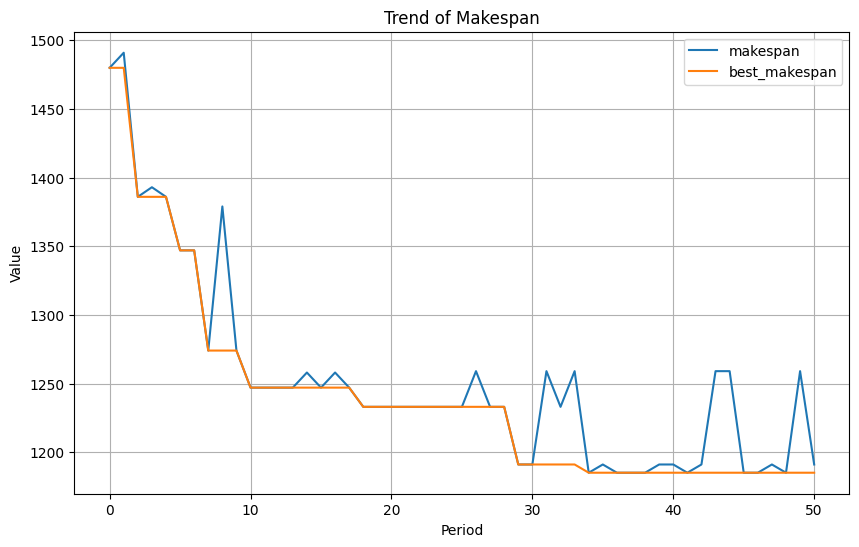

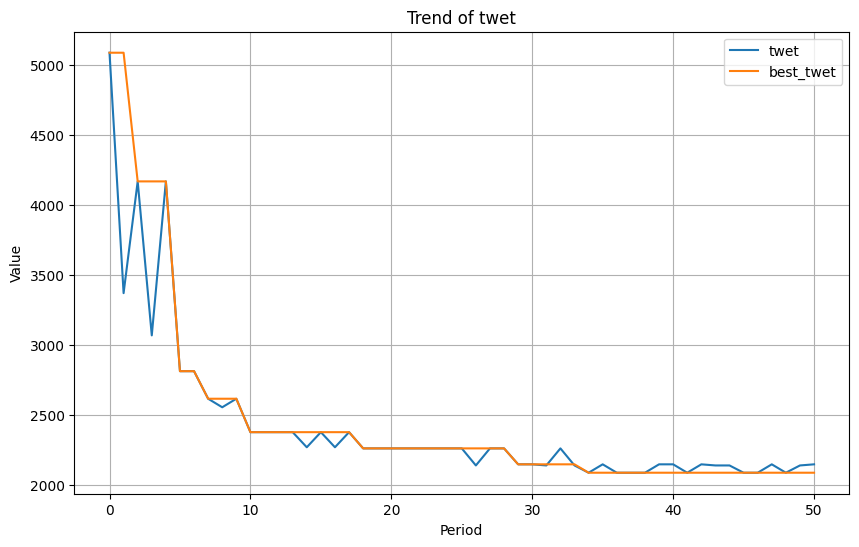

In [36]:

import matplotlib.pyplot as plt

makespan_data = [i[0] for i in line_graph_data]
twet_data = [i[1] for i in line_graph_data]
best_makespan_data = [i[0] for i in best_graph_data]
best_twet_data = [i[1] for i in best_graph_data]

x_axis = range(len(line_graph_data))

plt.figure(figsize=(10, 6))
plt.plot(x_axis, makespan_data, label='makespan')
plt.plot(x_axis, best_makespan_data, label='best_makespan')
plt.xlabel('Period')
plt.ylabel('Value')
plt.title('Trend of Makespan')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(x_axis, twet_data, label='twet')
plt.plot(x_axis, best_twet_data, label='best_twet')
plt.xlabel('Period')
plt.ylabel('Value')
plt.title('Trend of twet')
plt.legend()
plt.grid(True)
plt.show()
